# Bregman gradient methods for Poisson inverse problems

This notebook presents the experiments for Section 5.1., with a toy Poisson inverse problem where

$f(x) = D_{\rm KL}(b, Ax)$

and $b = Ax^*$ for some ground-truth signal $x^*$. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import rel_entr

In [2]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 13
plt.rcParams["lines.linewidth"] = 3

In [3]:
def D_KL(x,y):
    return np.sum(rel_entr(x,y) - x + y)

In [4]:
class PoissonObj():
    """Defines the Poisson inverse problem objective
        f(x) = D_KL(b, A * x)
    """
    
    
    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.n, self.d = A.shape[0], A.shape[1]
    
    def __call__(self, x, batch = "full"):
        """returns objective value and gradient
        can be set to stochasti if batch is set to a set of indices"""
        
        Ai, bi = A, b
        b_size = self.n
        
        if batch != "full":
            Ai, bi = A[batch,:], b[batch]
            b_size = len(batch)
        
        Aix = Ai.dot(x)
        obj_val = D_KL(bi, Aix) / b_size
        grad = (1 - bi / Aix).dot(Ai) / b_size
        
        return obj_val, grad

In [5]:
class LogKernel():
    """Log-barrier mirror kernel
        h(x) - sum_i log(x_i)
    """
    def bregman_step(self, x, g, step = 1.):
        denom = step * x * g + 1
        
        if denom.min() <= 0.:
            raise Error("Bregman gradient step is outside of nonnegative orthant. Step size might be too large")
            
        return x / denom

In [6]:
def BGD(obj, kernel, x0, step = 1., max_epochs = 1000):
    """vanilla bregman gradient descent with fixed step size"""
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
    
    for i in range(max_epochs):
        f_val, f_grad = obj(x)
        x = kernel.bregman_step(x, f_grad, step)
        
        F_vals.append(f_val)
        grad_evals.append(i+1)
        
    return x, F_vals, grad_evals

In [8]:
def B_SGD(obj, kernel, x0, step = 1., max_epochs = 1000):
    """Bregman SGD with fixed step size"""
    
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
    
    n = obj.n
    
    for i in range(max_epochs):
        f_val = 0.
        
        for j in range(n):            
            fj_val, fj_grad = obj(x, batch = [j])
            x = kernel.bregman_step(x, fj_grad, step)
            
            f_val += fj_val
            
        F_vals.append(f_val / n)
        grad_evals.append(i+1)
        
    return x, F_vals, grad_evals

In [9]:
def MU(obj, x0, max_epochs = 1000):
    """Standard baseline algorithm for Poisson problems.
    Multiplicative update, a.k.a. Lucy-Richardson or Expectation-minimization algorithm"""
    
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
        
    A, b = obj.A, obj.b
        
    for i in range(max_epochs):
        Ax = A.dot(x)
        f_val = D_KL(b, Ax) / A.shape[0]
        x = x * (b / Ax).dot(A) / A.sum(0)
        
        F_vals.append(f_val)
        grad_evals.append(i+1)
    
    return x, F_vals, grad_evals

## Running experiments

In [10]:
n = 10000
d = 1000

A = np.random.rand(n,d)
x_star = np.random.rand(d)

b = A @ x_star

f = PoissonObj(A, b)
x0 = np.random.rand(d)

max_epochs = 3000
L = b.sum() / n

In [11]:
step = 1. / L
    
_, F_BGD, T_BGD = BGD(f, LogKernel(), x0, step = step, max_epochs = max_epochs)

In [12]:
step = 1. / L
_, F_BSGD, T_BSGD = B_SGD(f, LogKernel(), x0, step = step, max_epochs = max_epochs)

In [14]:
_, F_MU, T_MU = MU(f, x0, max_epochs = max_epochs)

Text(0.5, 1.0, 'Poisson inverse problem')

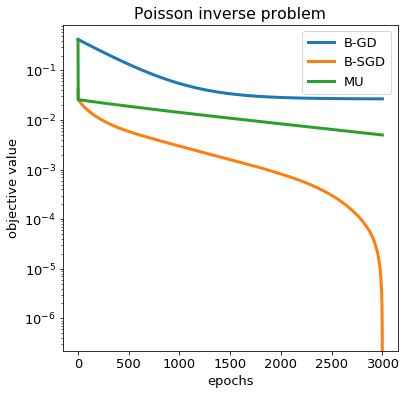

In [15]:
f_min = np.min([np.min(a) for a in [F_MU, F_BSGD]])

plt.plot(T_BGD, F_BGD - f_min, label = "B-GD")
plt.plot(T_BSGD, F_BSGD - f_min, label = "B-SGD")
plt.plot(T_MU, F_MU - f_min, label = "MU")

plt.semilogy()

plt.ylabel("objective value")
plt.xlabel("epochs")
plt.legend()
plt.title("Poisson inverse problem")